# Face Predictions using DeepFace

In [1]:
import itertools
import json
import os
from pathlib import Path
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import pandas as pd

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [2]:
def cv_imshow(image: np.ndarray, ax=plt) -> None:
    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax.axis('off')

def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+height] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

def prompt_extract(path: str) -> str:
    return ' '.join(path.split('_')[1:-1])

In [3]:
def draw_bbox(
    image: np.ndarray,
    bbox: List[int],
    text: Optional[str] = None,
    color: Tuple[int, int, int] = (255,)*3,
    thickness: int = 1,
    fontFace: int = cv.FONT_HERSHEY_SIMPLEX,
    fontScale: float = 0.5
) -> np.ndarray:
    
    cv.rectangle(
        image,
        bbox[:2],
        bbox[2:],
        color=color,
        thickness=thickness
    )
    
    if text:
        (_, h), _ = cv.getTextSize(
            text,
            fontFace=fontFace,
            fontScale=fontScale,
            thickness=thickness
        )
        cv.putText(
            image,
            text,
            (bbox[0], bbox[1]+h),
            fontFace=cv.FONT_HERSHEY_SIMPLEX,
            fontScale=fontScale,
            color=color,
            thickness=thickness
    )   
    
    return image

In [4]:
def image_equalize(
    image: np.ndarray,
    clipLimit: float=2.0,
    grid_size: int = 8
) -> np.ndarray:
    img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    img_l, img_a, img_b = cv.split(img_lab)
    
    clahe = cv.createCLAHE(
        clipLimit=clipLimit,
        tileGridSize=(grid_size, grid_size)
    )
    img_l = clahe.apply(img_l)
    
    img_lab = cv.merge((img_l, img_a, img_b))
    img_cl = cv.cvtColor(img_lab, cv.COLOR_LAB2BGR)
    return img_cl

In [5]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

df_actions = (
    'age',
    'gender',
    'race',
    'emotion'
)

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [6]:
def skin_color(
    image: np.ndarray,
    lower_quantile=0.4,
    upper_quantile=0.9
) -> Tuple[Tuple[int, int, int], np.ndarray]:
   
    img_l = cv.cvtColor(image, cv.COLOR_BGR2LAB)[:, :, 0]
    l_lower, l_upper = np.quantile(img_l, [lower_quantile, upper_quantile])
    
    mask = ((img_l >= l_lower) & (img_l <= l_upper))
    blue, green, red = image[mask].mean(axis=0)
    
    return (red, green, blue), mask

In [7]:
def color_show(color: Tuple[int, int, int], size=1, ax=None) -> None:
    color = tuple(c / 256 for c in color)
    rect = matplotlib.patches.Rectangle((0, 0), size, size, color=color)
    if ax is None:
        fig = plt.figure(figsize=(size, size))
        ax = fig.add_subplot(111)
    ax.add_patch(rect)
    ax.axis('off')

In [8]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

all_actions = df_actions + ('skin',)

df_default_models = {
    'age': DeepFace.build_model('Age'),
    'gender': DeepFace.build_model('Gender'),
    'emotion': DeepFace.build_model('Emotion'),
    'race': DeepFace.build_model('Race')
}

def image_predictions(
    image: np.ndarray,
    actions: Tuple[str] = ('gender', 'skin'),
    models: Optional[dict] = None,
    detector_backend: str = 'mtcnn',
    min_size: int = 20,
    equalize: bool = False
) -> Optional[dict]:
    
    assert(all(action in all_actions for action in actions))
    assert(detector_backend in df_backends)
    
    if equalize:
        image = image_equalize(image)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=(a for a in actions if a in df_actions),
            models=models,
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, (a for a in actions if a in df_actions))
        
            if 'skin' in actions:
                color, _ = skin_color(crop_bbox(image, predictions['bbox']))
                predictions['skin color'] = color
    except ValueError:
        pass
        
    return predictions

In [9]:
def quadrant_predictions(
    image: np.ndarray,
    **kwargs: dict,
) -> List[Optional[dict]]:
    
    results = []
    for bbox in quadrant_bboxes(image.shape[:2]):
        img_quadrant = crop_bbox(image, bbox)
        predictions = image_predictions(
            img_quadrant,
            **kwargs
        )
        if predictions:
            predictions['bbox'] = [x + y for x, y in zip(predictions['bbox'], bbox[:2]*2)]
        results.append(predictions)
    return results

In [10]:
midjourney_raw_root = Path('../../data/images/raw')

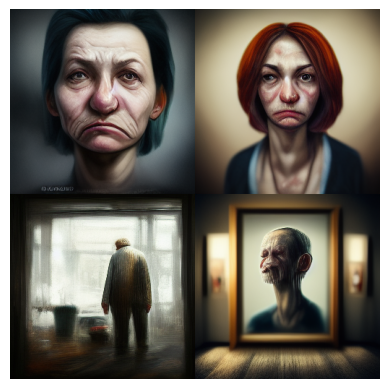

In [11]:
img_path = list(midjourney_raw_root.glob('*.png'))[0]


img_2x2 = cv.imread(str(img_path))
cv_imshow(img_2x2)

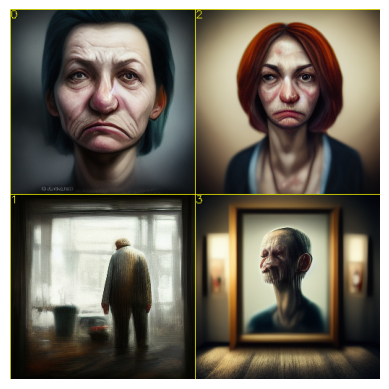

In [12]:
for i, bbox in enumerate(quadrant_bboxes(img_2x2.shape[:2])):
    draw_bbox(img_2x2, bbox, text=f'{i}', color=(0, 255, 255))

cv_imshow(img_2x2)

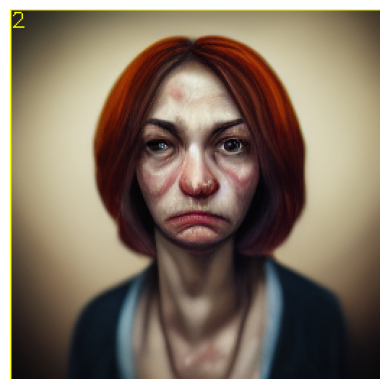

In [13]:
quadrant = 2
img_quad = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[quadrant])
cv_imshow(img_quad)

In [14]:
predictions = quadrant_predictions(img_2x2)
pprint(predictions[quadrant])

1/1 [==============================] - 1s 605ms/step
{'bbox': [332, 40, 430, 179],
 'gender': {'Man': 82.752925157547, 'Woman': 17.247070372104645},
 'skin color': (136.60283170340097, 103.44241716537732, 92.47555101445045)}


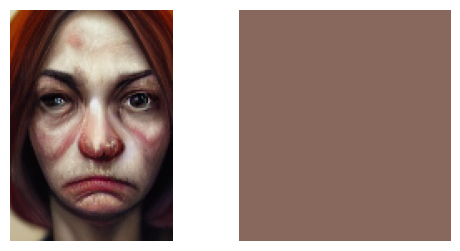

In [15]:
img_face = crop_bbox(img_2x2, predictions[quadrant]['bbox'])
color = predictions[quadrant]['skin color']

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
cv_imshow(img_face, ax=ax[0])
color_show(color, ax=ax[1])

In [16]:
kwargs = {
    'equalize': True,
    'actions': ('gender', 'skin'),
    'models': { 'gender': df_default_models['gender'] },
    'detector_backend': 'mtcnn'
}

all_predictions = []

for quad_path in tqdm(list(midjourney_raw_root.glob('*.png'))):
    quad_image = cv.imread(str(quad_path))
    prompt = prompt_extract(quad_path.stem)
    quad_predictions = [p if p else {} for p in quadrant_predictions(quad_image, **kwargs)]
    for idx, pred in enumerate(quad_predictions):
        pred['image'] = quad_path.stem
        pred['quadrant'] = idx
        pred['prompt'] = prompt
    all_predictions.extend(quad_predictions)

0it [00:00, ?it/s]

1/1 [==============================] - 1s 640ms/step


1it [00:13, 13.07s/it]

1/1 [==============================] - 1s 580ms/step


2it [00:25, 12.56s/it]

1/1 [==============================] - 1s 652ms/step


3it [00:39, 13.40s/it]

1/1 [==============================] - 1s 898ms/step


4it [00:51, 12.83s/it]

1/1 [==============================] - 1s 792ms/step


5it [01:06, 13.54s/it]

1/1 [==============================] - 1s 571ms/step


6it [01:20, 13.65s/it]

1/1 [==============================] - 1s 703ms/step


7it [01:34, 13.78s/it]

1/1 [==============================] - 0s 258ms/step


8it [01:44, 12.51s/it]

1/1 [==============================] - 0s 395ms/step


9it [01:58, 13.06s/it]

1/1 [==============================] - 0s 428ms/step


10it [02:12, 13.31s/it]

1/1 [==============================] - 0s 404ms/step


11it [02:26, 13.73s/it]

1/1 [==============================] - 1s 628ms/step


12it [02:43, 14.55s/it]

1/1 [==============================] - 1s 773ms/step


13it [02:58, 14.78s/it]

1/1 [==============================] - 0s 414ms/step


14it [03:11, 14.13s/it]

1/1 [==============================] - 0s 133ms/step


15it [03:24, 13.72s/it]

1/1 [==============================] - 0s 487ms/step


16it [03:38, 13.85s/it]

2/2 [==============================] - 0s 4ms/step


17it [03:50, 13.34s/it]

1/1 [==============================] - 0s 463ms/step


18it [04:02, 13.11s/it]

1/1 [==============================] - 0s 308ms/step


19it [04:15, 12.79s/it]

1/1 [==============================] - 1s 599ms/step


20it [04:27, 12.65s/it]

1/1 [==============================] - 1s 555ms/step


21it [04:41, 12.98s/it]

1/1 [==============================] - 0s 376ms/step


22it [04:53, 12.89s/it]

1/1 [==============================] - 1s 533ms/step


23it [05:06, 12.77s/it]

1/1 [==============================] - 0s 360ms/step


24it [05:19, 12.89s/it]

1/1 [==============================] - 0s 94ms/step


25it [05:32, 12.88s/it]

1/1 [==============================] - 0s 380ms/step


26it [05:44, 12.74s/it]

1/1 [==============================] - 0s 453ms/step


27it [05:58, 12.98s/it]

1/1 [==============================] - 0s 494ms/step


28it [06:11, 13.05s/it]

1/1 [==============================] - 0s 443ms/step


29it [06:23, 12.81s/it]

1/1 [==============================] - 0s 112ms/step


30it [06:34, 12.27s/it]

1/1 [==============================] - 1s 611ms/step


31it [06:48, 12.67s/it]

1/1 [==============================] - 0s 440ms/step


32it [07:02, 13.09s/it]

1/1 [==============================] - 1s 554ms/step


33it [07:16, 13.37s/it]

1/1 [==============================] - 0s 85ms/step


34it [07:29, 13.30s/it]

1/1 [==============================] - 1s 553ms/step


35it [07:45, 14.21s/it]

1/1 [==============================] - 1s 590ms/step


36it [08:00, 14.32s/it]

1/1 [==============================] - 0s 222ms/step


37it [08:08, 12.37s/it]

1/1 [==============================] - 0s 278ms/step


38it [08:13, 10.36s/it]

1/1 [==============================] - 0s 232ms/step


39it [08:19,  9.07s/it]

1/1 [==============================] - 0s 45ms/step


40it [08:24,  7.79s/it]

1/1 [==============================] - 0s 239ms/step


41it [08:29,  6.74s/it]

1/1 [==============================] - 0s 223ms/step


42it [08:33,  6.15s/it]

1/1 [==============================] - 0s 245ms/step


43it [08:38,  5.80s/it]

1/1 [==============================] - 0s 32ms/step


44it [08:42,  5.02s/it]

1/1 [==============================] - 0s 228ms/step


45it [08:46,  4.94s/it]

1/1 [==============================] - 0s 221ms/step


46it [08:51,  4.78s/it]

1/1 [==============================] - 0s 26ms/step


47it [08:55,  4.59s/it]

1/1 [==============================] - 0s 223ms/step


48it [08:59,  4.48s/it]

1/1 [==============================] - 0s 262ms/step


49it [09:04,  4.51s/it]

1/1 [==============================] - 0s 310ms/step


50it [09:08,  4.40s/it]

1/1 [==============================] - 0s 36ms/step


51it [09:11,  4.04s/it]

1/1 [==============================] - 0s 323ms/step


52it [09:16,  4.27s/it]

1/1 [==============================] - 0s 281ms/step


53it [09:21,  4.44s/it]

1/1 [==============================] - 0s 287ms/step


54it [09:25,  4.51s/it]

1/1 [==============================] - 0s 373ms/step


55it [09:30,  4.54s/it]

1/1 [==============================] - 0s 41ms/step


56it [09:33,  4.10s/it]

1/1 [==============================] - 0s 364ms/step


57it [09:38,  4.47s/it]

1/1 [==============================] - 0s 34ms/step


58it [09:43,  4.65s/it]

1/1 [==============================] - 0s 414ms/step


59it [09:49,  4.99s/it]

1/1 [==============================] - 0s 437ms/step


60it [09:53,  4.76s/it]

1/1 [==============================] - 1s 531ms/step


61it [10:01,  5.72s/it]

1/1 [==============================] - 1s 748ms/step


62it [10:08,  6.06s/it]

1/1 [==============================] - 0s 51ms/step


63it [10:15,  6.20s/it]

1/1 [==============================] - 1s 521ms/step


64it [10:21,  6.28s/it]

1/1 [==============================] - 1s 550ms/step


65it [10:26,  5.94s/it]

1/1 [==============================] - 1s 575ms/step


66it [10:32,  5.98s/it]

1/1 [==============================] - 1s 508ms/step


67it [10:39,  6.30s/it]

1/1 [==============================] - 0s 32ms/step


68it [10:44,  5.82s/it]

1/1 [==============================] - 1s 528ms/step


69it [10:50,  5.75s/it]

1/1 [==============================] - 1s 573ms/step


70it [10:55,  5.62s/it]

1/1 [==============================] - 1s 624ms/step


71it [11:02,  5.97s/it]

1/1 [==============================] - 1s 631ms/step


72it [11:09,  6.21s/it]

1/1 [==============================] - 1s 727ms/step


73it [11:15,  6.19s/it]

1/1 [==============================] - 1s 591ms/step


74it [11:22,  6.35s/it]

1/1 [==============================] - 1s 548ms/step


75it [11:28,  6.39s/it]

1/1 [==============================] - 1s 601ms/step


76it [11:35,  6.63s/it]

1/1 [==============================] - 0s 35ms/step


77it [11:41,  6.39s/it]

1/1 [==============================] - 1s 665ms/step


78it [11:48,  6.66s/it]

1/1 [==============================] - 1s 645ms/step


79it [11:56,  6.86s/it]

1/1 [==============================] - 1s 630ms/step


80it [12:03,  6.91s/it]

1/1 [==============================] - 1s 703ms/step


81it [12:10,  6.98s/it]

1/1 [==============================] - 1s 721ms/step


82it [12:17,  7.08s/it]

1/1 [==============================] - 1s 777ms/step


83it [12:24,  7.17s/it]

1/1 [==============================] - 1s 669ms/step


84it [12:31,  7.04s/it]

1/1 [==============================] - 1s 601ms/step


85it [12:38,  7.01s/it]

1/1 [==============================] - 1s 800ms/step


86it [12:45,  6.86s/it]

1/1 [==============================] - 1s 797ms/step


87it [12:51,  6.79s/it]

1/1 [==============================] - 1s 659ms/step


88it [12:58,  6.81s/it]

1/1 [==============================] - 1s 764ms/step


89it [13:05,  6.80s/it]

1/1 [==============================] - 0s 42ms/step


90it [13:10,  6.34s/it]

1/1 [==============================] - 1s 839ms/step


91it [13:18,  6.74s/it]

1/1 [==============================] - 1s 791ms/step


92it [13:26,  7.04s/it]

1/1 [==============================] - 0s 39ms/step


93it [13:31,  6.56s/it]

1/1 [==============================] - 1s 791ms/step


94it [13:39,  6.96s/it]

1/1 [==============================] - 1s 710ms/step


95it [13:46,  6.90s/it]

1/1 [==============================] - 1s 801ms/step


96it [13:52,  6.85s/it]

1/1 [==============================] - 1s 819ms/step


97it [13:58,  6.59s/it]

1/1 [==============================] - 1s 867ms/step


98it [14:05,  6.64s/it]

1/1 [==============================] - 0s 28ms/step


99it [14:11,  6.35s/it]

1/1 [==============================] - 1s 824ms/step


100it [14:18,  6.73s/it]

1/1 [==============================] - 1s 992ms/step


101it [14:27,  7.24s/it]

1/1 [==============================] - 1s 820ms/step


102it [14:35,  7.45s/it]

1/1 [==============================] - 1s 1s/step


103it [14:43,  7.60s/it]

1/1 [==============================] - 0s 34ms/step


104it [14:46,  6.33s/it]

1/1 [==============================] - 1s 853ms/step


105it [14:53,  6.49s/it]

1/1 [==============================] - 1s 845ms/step


106it [15:01,  6.97s/it]

1/1 [==============================] - 1s 814ms/step


107it [15:08,  6.89s/it]

1/1 [==============================] - 1s 884ms/step


108it [15:16,  7.36s/it]

1/1 [==============================] - 1s 846ms/step


109it [15:25,  7.69s/it]

1/1 [==============================] - 0s 62ms/step


110it [15:31,  7.28s/it]

1/1 [==============================] - 1s 899ms/step


111it [15:40,  7.63s/it]

1/1 [==============================] - 1s 912ms/step


112it [15:47,  7.73s/it]

1/1 [==============================] - 1s 827ms/step


113it [15:55,  7.79s/it]

1/1 [==============================] - 1s 990ms/step


114it [16:04,  7.93s/it]

1/1 [==============================] - 1s 987ms/step


115it [16:12,  8.06s/it]

1/1 [==============================] - 1s 1s/step


116it [16:18,  7.57s/it]

1/1 [==============================] - 1s 1s/step


117it [16:27,  7.89s/it]

1/1 [==============================] - 1s 929ms/step


118it [16:34,  7.72s/it]

1/1 [==============================] - 1s 1s/step


119it [16:43,  8.00s/it]

1/1 [==============================] - 1s 986ms/step


120it [16:52,  8.28s/it]

1/1 [==============================] - 1s 1s/step


121it [17:01,  8.55s/it]

1/1 [==============================] - 1s 1s/step


122it [17:07,  7.85s/it]

1/1 [==============================] - 1s 1s/step


123it [17:16,  8.21s/it]

1/1 [==============================] - 0s 43ms/step


124it [17:24,  8.01s/it]

1/1 [==============================] - 1s 975ms/step


125it [17:30,  7.45s/it]

1/1 [==============================] - 1s 1s/step


126it [17:39,  7.89s/it]

1/1 [==============================] - 1s 1s/step


127it [17:48,  8.28s/it]

1/1 [==============================] - 0s 50ms/step


128it [17:52,  7.04s/it]

1/1 [==============================] - 1s 1s/step


129it [18:00,  7.18s/it]

1/1 [==============================] - 1s 1s/step


130it [18:09,  7.62s/it]

1/1 [==============================] - 1s 1s/step


131it [18:18,  8.32s/it]

1/1 [==============================] - 1s 1s/step


132it [18:28,  8.57s/it]

1/1 [==============================] - 1s 1s/step


133it [18:36,  8.55s/it]

1/1 [==============================] - 1s 1s/step


134it [18:43,  8.12s/it]

1/1 [==============================] - 1s 1s/step


135it [18:50,  7.85s/it]

1/1 [==============================] - 1s 1s/step


136it [18:59,  8.15s/it]

1/1 [==============================] - 1s 1s/step


137it [19:08,  8.30s/it]

1/1 [==============================] - 1s 1s/step


138it [19:15,  8.01s/it]

1/1 [==============================] - 1s 1s/step


139it [19:21,  7.34s/it]

1/1 [==============================] - 1s 1s/step


140it [19:28,  7.32s/it]

1/1 [==============================] - 1s 1s/step


141it [19:37,  7.75s/it]

1/1 [==============================] - 1s 1s/step


142it [19:46,  8.11s/it]

1/1 [==============================] - 1s 1s/step


143it [19:53,  7.88s/it]

1/1 [==============================] - 1s 1s/step


144it [20:02,  8.14s/it]

1/1 [==============================] - 0s 35ms/step


145it [20:07,  7.10s/it]

1/1 [==============================] - 0s 33ms/step


146it [20:13,  6.85s/it]

1/1 [==============================] - 1s 1s/step


147it [20:21,  7.24s/it]

1/1 [==============================] - 1s 1s/step


148it [20:29,  7.53s/it]

1/1 [==============================] - 1s 1s/step


149it [20:38,  7.94s/it]

1/1 [==============================] - 1s 1s/step


150it [20:44,  7.27s/it]

1/1 [==============================] - 1s 1s/step


151it [20:53,  7.84s/it]

1/1 [==============================] - 1s 1s/step


152it [21:02,  8.26s/it]

1/1 [==============================] - 1s 1s/step


153it [21:12,  8.55s/it]

1/1 [==============================] - 1s 1s/step


154it [21:20,  8.37s/it]

1/1 [==============================] - 1s 1s/step


155it [21:29,  8.76s/it]

1/1 [==============================] - 1s 1s/step


156it [21:39,  9.01s/it]

1/1 [==============================] - 1s 1s/step


157it [21:48,  9.11s/it]

1/1 [==============================] - 1s 1s/step


158it [21:58,  9.16s/it]

1/1 [==============================] - 0s 31ms/step


159it [22:04,  8.38s/it]

1/1 [==============================] - 1s 1s/step


160it [22:12,  8.30s/it]

1/1 [==============================] - 1s 1s/step


161it [22:21,  8.43s/it]

1/1 [==============================] - 1s 1s/step


162it [22:30,  8.65s/it]

1/1 [==============================] - 1s 1s/step


163it [22:38,  8.37s/it]

1/1 [==============================] - 0s 32ms/step


164it [22:41,  6.74s/it]

1/1 [==============================] - 1s 1s/step


165it [22:50,  7.39s/it]

1/1 [==============================] - 1s 1s/step


166it [22:59,  7.97s/it]

1/1 [==============================] - 1s 1s/step


167it [23:09,  8.49s/it]

1/1 [==============================] - 0s 35ms/step


168it [23:14,  7.40s/it]

1/1 [==============================] - 2s 2s/step


169it [23:24,  8.28s/it]

1/1 [==============================] - 1s 1s/step


170it [23:34,  8.74s/it]

1/1 [==============================] - 0s 81ms/step


171it [23:39,  7.72s/it]

1/1 [==============================] - 0s 66ms/step


172it [23:48,  8.05s/it]

1/1 [==============================] - 0s 33ms/step


173it [23:56,  8.18s/it]

1/1 [==============================] - 1s 1s/step


174it [24:05,  8.37s/it]

1/1 [==============================] - 1s 1s/step


175it [24:16,  8.99s/it]

2/2 [==============================] - 0s 17ms/step


176it [24:21,  7.87s/it]

1/1 [==============================] - 1s 1s/step


177it [24:31,  8.58s/it]

1/1 [==============================] - 1s 1s/step


178it [24:39,  8.53s/it]

1/1 [==============================] - 2s 2s/step


179it [24:50,  9.14s/it]

2/2 [==============================] - 0s 17ms/step


180it [24:56,  8.11s/it]

1/1 [==============================] - 2s 2s/step


181it [25:07,  9.13s/it]

1/1 [==============================] - 2s 2s/step


182it [25:17,  9.24s/it]

1/1 [==============================] - 2s 2s/step


183it [25:28,  9.73s/it]

1/1 [==============================] - 2s 2s/step


184it [25:39, 10.08s/it]

1/1 [==============================] - 2s 2s/step


185it [25:49, 10.17s/it]

1/1 [==============================] - 2s 2s/step


186it [26:00, 10.31s/it]

1/1 [==============================] - 2s 2s/step


187it [26:09, 10.12s/it]

1/1 [==============================] - 0s 48ms/step


188it [26:15,  8.96s/it]

1/1 [==============================] - 2s 2s/step


189it [26:25,  9.27s/it]

1/1 [==============================] - 2s 2s/step


190it [26:34,  9.01s/it]

1/1 [==============================] - 2s 2s/step


191it [26:43,  9.04s/it]

1/1 [==============================] - 2s 2s/step


192it [26:54,  9.76s/it]

1/1 [==============================] - 0s 40ms/step


193it [27:04,  9.60s/it]

1/1 [==============================] - 1s 1s/step


194it [27:15, 10.23s/it]

1/1 [==============================] - 2s 2s/step


195it [27:28, 10.94s/it]

1/1 [==============================] - 2s 2s/step


196it [27:41, 11.53s/it]

1/1 [==============================] - 2s 2s/step


197it [27:51, 11.10s/it]

1/1 [==============================] - 2s 2s/step


198it [28:04, 11.63s/it]

1/1 [==============================] - 0s 34ms/step


199it [28:15, 11.35s/it]

1/1 [==============================] - 2s 2s/step


200it [28:27, 11.65s/it]

1/1 [==============================] - 0s 29ms/step


201it [28:37, 11.16s/it]

1/1 [==============================] - 2s 2s/step


202it [28:48, 11.29s/it]

1/1 [==============================] - 0s 64ms/step


203it [28:54,  9.66s/it]

1/1 [==============================] - 2s 2s/step


204it [29:06, 10.32s/it]

1/1 [==============================] - 2s 2s/step


205it [29:18, 10.77s/it]

1/1 [==============================] - 2s 2s/step


206it [29:30, 11.15s/it]

1/1 [==============================] - 2s 2s/step


207it [29:38, 10.32s/it]

1/1 [==============================] - 2s 2s/step


208it [29:50, 10.74s/it]

1/1 [==============================] - 2s 2s/step


209it [30:02, 11.06s/it]

1/1 [==============================] - 0s 37ms/step


210it [30:11, 10.59s/it]

1/1 [==============================] - 2s 2s/step


211it [30:23, 10.98s/it]

1/1 [==============================] - 2s 2s/step


212it [30:36, 11.36s/it]

1/1 [==============================] - 2s 2s/step


213it [30:48, 11.63s/it]

1/1 [==============================] - 2s 2s/step


214it [30:58, 11.23s/it]

1/1 [==============================] - 2s 2s/step


215it [31:10, 11.55s/it]

1/1 [==============================] - 2s 2s/step


216it [31:21, 11.16s/it]

1/1 [==============================] - 0s 70ms/step


217it [31:31, 10.76s/it]

1/1 [==============================] - 2s 2s/step


218it [31:43, 11.14s/it]

1/1 [==============================] - 0s 63ms/step


219it [31:48,  9.29s/it]

1/1 [==============================] - 3s 3s/step


220it [32:04, 11.45s/it]

1/1 [==============================] - 2s 2s/step


221it [32:20, 12.81s/it]

1/1 [==============================] - 2s 2s/step


222it [32:35, 13.33s/it]

1/1 [==============================] - 3s 3s/step


223it [32:51, 14.40s/it]

2/2 [==============================] - 0s 36ms/step


224it [32:57, 11.60s/it]

1/1 [==============================] - 2s 2s/step


225it [33:12, 12.76s/it]

1/1 [==============================] - 3s 3s/step


226it [33:26, 13.01s/it]

1/1 [==============================] - 0s 55ms/step


227it [33:35, 12.00s/it]

1/1 [==============================] - 3s 3s/step


228it [33:49, 12.58s/it]

1/1 [==============================] - 2s 2s/step


229it [34:05, 13.69s/it]

1/1 [==============================] - 0s 59ms/step


230it [34:19, 13.58s/it]

1/1 [==============================] - 3s 3s/step


231it [34:35, 14.43s/it]

1/1 [==============================] - 2s 2s/step


232it [34:49, 14.39s/it]

1/1 [==============================] - 2s 2s/step


233it [35:05, 14.70s/it]

1/1 [==============================] - 3s 3s/step


234it [35:19, 14.51s/it]

1/1 [==============================] - 2s 2s/step


235it [35:33, 14.23s/it]

1/1 [==============================] - 3s 3s/step


236it [35:48, 14.69s/it]

1/1 [==============================] - 3s 3s/step


237it [36:01, 14.02s/it]

1/1 [==============================] - 2s 2s/step


238it [36:17, 14.56s/it]

1/1 [==============================] - 2s 2s/step


239it [36:32, 14.88s/it]

1/1 [==============================] - 3s 3s/step


240it [36:49, 15.36s/it]

1/1 [==============================] - 3s 3s/step


241it [37:05, 15.65s/it]

1/1 [==============================] - 2s 2s/step


242it [37:20, 15.35s/it]

1/1 [==============================] - 2s 2s/step


243it [37:32, 14.41s/it]

1/1 [==============================] - 2s 2s/step


244it [37:42, 13.17s/it]

1/1 [==============================] - 3s 3s/step


245it [37:56, 13.32s/it]

1/1 [==============================] - 0s 83ms/step


246it [38:06, 12.43s/it]

1/1 [==============================] - 2s 2s/step


247it [38:22, 13.45s/it]

1/1 [==============================] - 3s 3s/step


248it [38:30, 11.67s/it]

1/1 [==============================] - 3s 3s/step


249it [38:42, 12.05s/it]

1/1 [==============================] - 3s 3s/step


250it [38:58, 13.05s/it]

1/1 [==============================] - 2s 2s/step


251it [39:14, 14.06s/it]

1/1 [==============================] - 3s 3s/step


252it [39:30, 14.67s/it]

1/1 [==============================] - 2s 2s/step


253it [39:44, 14.30s/it]

1/1 [==============================] - 0s 85ms/step


254it [39:55, 13.33s/it]

1/1 [==============================] - 0s 51ms/step


255it [40:06, 12.68s/it]

1/1 [==============================] - 2s 2s/step


256it [40:23, 14.03s/it]

1/1 [==============================] - 3s 3s/step


257it [40:41, 15.03s/it]

1/1 [==============================] - 3s 3s/step


258it [40:59, 15.96s/it]

1/1 [==============================] - 0s 66ms/step


259it [41:10, 14.68s/it]

1/1 [==============================] - 3s 3s/step


260it [41:28, 15.44s/it]

1/1 [==============================] - 3s 3s/step


261it [41:44, 15.83s/it]

1/1 [==============================] - 0s 110ms/step


262it [41:52, 13.35s/it]

1/1 [==============================] - 3s 3s/step


263it [42:09, 14.45s/it]

1/1 [==============================] - 3s 3s/step


264it [42:26, 15.13s/it]

1/1 [==============================] - 0s 89ms/step


265it [42:36, 13.75s/it]

1/1 [==============================] - 3s 3s/step


266it [42:47, 12.89s/it]

1/1 [==============================] - 3s 3s/step


267it [43:04, 14.22s/it]

1/1 [==============================] - 3s 3s/step


268it [43:18, 14.02s/it]

1/1 [==============================] - 3s 3s/step


269it [43:32, 14.10s/it]

1/1 [==============================] - 0s 119ms/step


270it [43:37, 11.41s/it]

1/1 [==============================] - 0s 50ms/step


271it [43:51, 12.02s/it]

1/1 [==============================] - 3s 3s/step


272it [44:08, 13.57s/it]

1/1 [==============================] - 3s 3s/step


273it [44:26, 14.80s/it]

1/1 [==============================] - 3s 3s/step


274it [44:37, 13.74s/it]

1/1 [==============================] - 3s 3s/step


275it [44:54, 14.75s/it]

1/1 [==============================] - 3s 3s/step


276it [45:12, 15.65s/it]

1/1 [==============================] - 3s 3s/step


277it [45:30, 16.29s/it]

1/1 [==============================] - 3s 3s/step


278it [45:47, 16.70s/it]

1/1 [==============================] - 3s 3s/step


279it [46:05, 17.10s/it]

1/1 [==============================] - 3s 3s/step


280it [46:23, 17.34s/it]

1/1 [==============================] - 3s 3s/step


281it [46:41, 17.64s/it]

1/1 [==============================] - 3s 3s/step


282it [47:00, 17.99s/it]

1/1 [==============================] - 3s 3s/step


283it [47:19, 18.28s/it]

1/1 [==============================] - 0s 96ms/step


284it [47:31, 16.29s/it]

1/1 [==============================] - 3s 3s/step


285it [47:49, 16.77s/it]

1/1 [==============================] - 3s 3s/step


286it [48:08, 17.48s/it]

1/1 [==============================] - 3s 3s/step


287it [48:26, 17.79s/it]

1/1 [==============================] - 0s 32ms/step


288it [48:42, 17.17s/it]

1/1 [==============================] - 3s 3s/step


289it [49:01, 17.80s/it]

1/1 [==============================] - 3s 3s/step


290it [49:20, 18.12s/it]

2/2 [==============================] - 0s 31ms/step


291it [49:26, 14.35s/it]

1/1 [==============================] - 3s 3s/step


292it [49:45, 15.65s/it]

1/1 [==============================] - 3s 3s/step


293it [50:00, 15.66s/it]

1/1 [==============================] - 3s 3s/step


294it [50:20, 16.90s/it]

1/1 [==============================] - 4s 4s/step


295it [50:36, 16.77s/it]

1/1 [==============================] - 4s 4s/step


296it [50:49, 15.62s/it]

1/1 [==============================] - 3s 3s/step


297it [51:09, 16.85s/it]

1/1 [==============================] - 3s 3s/step


298it [51:24, 16.18s/it]

1/1 [==============================] - 3s 3s/step


299it [51:38, 15.73s/it]

1/1 [==============================] - 3s 3s/step


300it [51:53, 15.41s/it]

1/1 [==============================] - 3s 3s/step


301it [52:08, 15.27s/it]

1/1 [==============================] - 0s 79ms/step


302it [52:19, 14.09s/it]

1/1 [==============================] - 0s 88ms/step


303it [52:31, 13.49s/it]

1/1 [==============================] - 3s 3s/step


304it [52:49, 14.68s/it]

1/1 [==============================] - 4s 4s/step


305it [53:11, 16.78s/it]

1/1 [==============================] - 3s 3s/step


306it [53:30, 17.67s/it]

1/1 [==============================] - 3s 3s/step


307it [53:48, 17.66s/it]

1/1 [==============================] - 0s 65ms/step


308it [53:56, 14.79s/it]

1/1 [==============================] - 3s 3s/step


309it [54:08, 13.79s/it]

1/1 [==============================] - 3s 3s/step


310it [54:27, 15.50s/it]

1/1 [==============================] - 3s 3s/step


311it [54:45, 16.38s/it]

1/1 [==============================] - 3s 3s/step


312it [55:05, 17.29s/it]

1/1 [==============================] - 4s 4s/step


313it [55:25, 18.02s/it]

1/1 [==============================] - 4s 4s/step


314it [55:44, 18.57s/it]

1/1 [==============================] - 3s 3s/step


315it [56:05, 19.09s/it]

1/1 [==============================] - 4s 4s/step


316it [56:25, 19.39s/it]

1/1 [==============================] - 3s 3s/step


317it [56:41, 18.48s/it]

1/1 [==============================] - 4s 4s/step


318it [57:02, 19.09s/it]

1/1 [==============================] - 4s 4s/step


319it [57:24, 20.04s/it]

1/1 [==============================] - 4s 4s/step


320it [57:44, 20.06s/it]

1/1 [==============================] - 0s 86ms/step


321it [58:00, 18.86s/it]

1/1 [==============================] - 3s 3s/step


322it [58:20, 19.31s/it]

1/1 [==============================] - 0s 100ms/step


323it [58:36, 18.23s/it]

1/1 [==============================] - 3s 3s/step


324it [58:55, 18.50s/it]

1/1 [==============================] - 4s 4s/step


325it [59:15, 18.87s/it]

1/1 [==============================] - 4s 4s/step


326it [59:35, 19.17s/it]

1/1 [==============================] - 4s 4s/step


327it [59:52, 18.45s/it]

1/1 [==============================] - 3s 3s/step


328it [1:00:11, 18.82s/it]

1/1 [==============================] - 4s 4s/step


329it [1:00:33, 19.64s/it]

1/1 [==============================] - 0s 68ms/step


330it [1:00:38, 15.19s/it]

1/1 [==============================] - 4s 4s/step


331it [1:00:59, 17.01s/it]

1/1 [==============================] - 3s 3s/step


332it [1:01:16, 17.02s/it]

1/1 [==============================] - 4s 4s/step


333it [1:01:29, 15.82s/it]

1/1 [==============================] - 4s 4s/step


334it [1:01:46, 16.23s/it]

1/1 [==============================] - 0s 69ms/step


335it [1:01:56, 14.34s/it]

1/1 [==============================] - 4s 4s/step


336it [1:02:17, 16.24s/it]

1/1 [==============================] - 0s 96ms/step


337it [1:02:26, 14.19s/it]

1/1 [==============================] - 4s 4s/step


338it [1:02:45, 15.44s/it]

1/1 [==============================] - 4s 4s/step


339it [1:03:06, 17.23s/it]

1/1 [==============================] - 3s 3s/step


340it [1:03:26, 18.01s/it]

1/1 [==============================] - 4s 4s/step


341it [1:03:42, 17.39s/it]

1/1 [==============================] - 4s 4s/step


342it [1:04:03, 18.52s/it]

1/1 [==============================] - 4s 4s/step


343it [1:04:24, 19.43s/it]

1/1 [==============================] - 0s 33ms/step


344it [1:04:29, 14.95s/it]

1/1 [==============================] - 4s 4s/step


345it [1:04:50, 16.83s/it]

1/1 [==============================] - 4s 4s/step


346it [1:05:12, 18.34s/it]

1/1 [==============================] - 0s 83ms/step


347it [1:05:31, 18.44s/it]

1/1 [==============================] - 4s 4s/step


348it [1:05:52, 19.18s/it]

1/1 [==============================] - 4s 4s/step


349it [1:06:10, 18.96s/it]

2/2 [==============================] - 0s 41ms/step


350it [1:06:23, 17.14s/it]

1/1 [==============================] - 4s 4s/step


351it [1:06:45, 18.61s/it]

1/1 [==============================] - 5s 5s/step


352it [1:07:00, 17.65s/it]

1/1 [==============================] - 4s 4s/step


353it [1:07:26, 19.95s/it]

1/1 [==============================] - 5s 5s/step


354it [1:07:52, 21.89s/it]

1/1 [==============================] - 5s 5s/step


355it [1:08:19, 23.29s/it]

1/1 [==============================] - 0s 83ms/step


356it [1:08:39, 22.45s/it]

1/1 [==============================] - 5s 5s/step


357it [1:09:05, 23.58s/it]

1/1 [==============================] - 5s 5s/step


358it [1:09:32, 24.46s/it]

1/1 [==============================] - 5s 5s/step


359it [1:09:58, 24.97s/it]

1/1 [==============================] - 4s 4s/step


360it [1:10:22, 24.63s/it]

1/1 [==============================] - 4s 4s/step


361it [1:10:44, 23.76s/it]

1/1 [==============================] - 0s 88ms/step


362it [1:11:00, 21.57s/it]

1/1 [==============================] - 4s 4s/step


363it [1:11:21, 21.37s/it]

1/1 [==============================] - 0s 99ms/step


364it [1:11:34, 18.80s/it]

1/1 [==============================] - 0s 144ms/step


365it [1:11:50, 18.14s/it]

1/1 [==============================] - 3s 3s/step


366it [1:12:03, 16.42s/it]

1/1 [==============================] - 4s 4s/step


367it [1:12:24, 17.95s/it]

1/1 [==============================] - 0s 64ms/step


368it [1:12:29, 13.91s/it]

1/1 [==============================] - 0s 100ms/step


369it [1:12:46, 14.92s/it]

1/1 [==============================] - 5s 5s/step


370it [1:13:11, 17.79s/it]

1/1 [==============================] - 4s 4s/step


371it [1:13:34, 19.44s/it]

1/1 [==============================] - 4s 4s/step


372it [1:13:56, 20.15s/it]

1/1 [==============================] - 4s 4s/step


373it [1:14:16, 20.33s/it]

1/1 [==============================] - 4s 4s/step


374it [1:14:39, 20.84s/it]

1/1 [==============================] - 4s 4s/step


375it [1:15:01, 21.24s/it]

1/1 [==============================] - 4s 4s/step


376it [1:15:23, 21.69s/it]

1/1 [==============================] - 4s 4s/step


377it [1:15:47, 22.16s/it]

1/1 [==============================] - 4s 4s/step


378it [1:16:10, 22.57s/it]

1/1 [==============================] - 4s 4s/step


379it [1:16:28, 21.04s/it]

1/1 [==============================] - 4s 4s/step


380it [1:16:46, 20.20s/it]

1/1 [==============================] - 4s 4s/step


381it [1:17:09, 21.07s/it]

1/1 [==============================] - 4s 4s/step


382it [1:17:27, 20.20s/it]

1/1 [==============================] - 4s 4s/step


383it [1:17:51, 21.22s/it]

1/1 [==============================] - 4s 4s/step


384it [1:18:14, 21.85s/it]

1/1 [==============================] - 5s 5s/step


385it [1:18:25, 18.48s/it]

1/1 [==============================] - 4s 4s/step


386it [1:18:44, 18.57s/it]

1/1 [==============================] - 5s 5s/step


387it [1:19:02, 18.67s/it]

1/1 [==============================] - 4s 4s/step


388it [1:19:26, 20.10s/it]

1/1 [==============================] - 4s 4s/step


389it [1:19:48, 20.76s/it]

1/1 [==============================] - 0s 128ms/step


390it [1:19:54, 16.17s/it]

1/1 [==============================] - 5s 5s/step


391it [1:20:18, 18.67s/it]

1/1 [==============================] - 5s 5s/step


392it [1:20:42, 20.25s/it]

1/1 [==============================] - 5s 5s/step


393it [1:21:07, 21.64s/it]

1/1 [==============================] - 0s 168ms/step


394it [1:21:27, 21.27s/it]

1/1 [==============================] - 4s 4s/step


395it [1:21:49, 21.24s/it]

1/1 [==============================] - 4s 4s/step


396it [1:22:14, 22.40s/it]

1/1 [==============================] - 4s 4s/step


397it [1:22:38, 23.02s/it]

1/1 [==============================] - 5s 5s/step


398it [1:22:58, 22.17s/it]

1/1 [==============================] - 5s 5s/step


399it [1:23:23, 22.92s/it]

1/1 [==============================] - 5s 5s/step


400it [1:23:48, 23.57s/it]

1/1 [==============================] - 0s 144ms/step


401it [1:24:09, 22.70s/it]

1/1 [==============================] - 5s 5s/step


402it [1:24:34, 23.57s/it]

1/1 [==============================] - 4s 4s/step


403it [1:24:54, 22.53s/it]

1/1 [==============================] - 5s 5s/step


404it [1:25:04, 18.67s/it]

1/1 [==============================] - 5s 5s/step


405it [1:25:27, 20.00s/it]

1/1 [==============================] - 4s 4s/step


406it [1:25:52, 21.49s/it]

1/1 [==============================] - 5s 5s/step


407it [1:26:19, 23.08s/it]

1/1 [==============================] - 5s 5s/step


408it [1:26:46, 24.31s/it]

1/1 [==============================] - 5s 5s/step


409it [1:27:13, 25.17s/it]

1/1 [==============================] - 5s 5s/step


410it [1:27:36, 24.53s/it]

1/1 [==============================] - 0s 184ms/step


411it [1:27:48, 20.67s/it]

1/1 [==============================] - 5s 5s/step


412it [1:28:14, 22.15s/it]

1/1 [==============================] - 6s 6s/step


413it [1:28:42, 24.10s/it]

1/1 [==============================] - 6s 6s/step


414it [1:29:14, 26.34s/it]

1/1 [==============================] - 6s 6s/step


415it [1:29:44, 27.57s/it]

1/1 [==============================] - 0s 118ms/step


416it [1:29:50, 21.03s/it]

1/1 [==============================] - 5s 5s/step


417it [1:30:18, 23.04s/it]

1/1 [==============================] - 5s 5s/step


418it [1:30:35, 21.34s/it]

1/1 [==============================] - 5s 5s/step


419it [1:31:03, 23.18s/it]

1/1 [==============================] - 0s 142ms/step


420it [1:31:09, 18.13s/it]

1/1 [==============================] - 5s 5s/step


421it [1:31:30, 18.99s/it]

1/1 [==============================] - 4s 4s/step


422it [1:31:45, 17.86s/it]

1/1 [==============================] - 5s 5s/step


423it [1:32:07, 18.91s/it]

1/1 [==============================] - 5s 5s/step


424it [1:32:28, 19.78s/it]

1/1 [==============================] - 5s 5s/step


425it [1:32:50, 20.41s/it]

1/1 [==============================] - 6s 6s/step


426it [1:33:13, 21.02s/it]

1/1 [==============================] - 6s 6s/step


427it [1:33:42, 23.42s/it]

1/1 [==============================] - 0s 103ms/step


428it [1:34:06, 23.78s/it]

1/1 [==============================] - 5s 5s/step


429it [1:34:34, 24.90s/it]

1/1 [==============================] - 0s 91ms/step


430it [1:34:52, 22.86s/it]

1/1 [==============================] - 6s 6s/step


431it [1:35:09, 21.06s/it]

1/1 [==============================] - 6s 6s/step


432it [1:35:38, 23.38s/it]

1/1 [==============================] - 6s 6s/step


433it [1:36:06, 25.01s/it]

1/1 [==============================] - 6s 6s/step


434it [1:36:34, 25.83s/it]

1/1 [==============================] - 5s 5s/step


435it [1:37:06, 27.53s/it]

1/1 [==============================] - 5s 5s/step


436it [1:37:36, 28.33s/it]

1/1 [==============================] - 6s 6s/step


437it [1:38:01, 27.33s/it]

1/1 [==============================] - 0s 190ms/step


438it [1:38:25, 26.28s/it]

1/1 [==============================] - 6s 6s/step


439it [1:38:53, 26.82s/it]

1/1 [==============================] - 5s 5s/step


440it [1:39:16, 25.87s/it]

1/1 [==============================] - 5s 5s/step


441it [1:39:33, 23.19s/it]

1/1 [==============================] - 6s 6s/step


442it [1:39:57, 23.34s/it]

1/1 [==============================] - 6s 6s/step


443it [1:40:28, 25.76s/it]

1/1 [==============================] - 6s 6s/step


444it [1:40:59, 27.13s/it]

1/1 [==============================] - 6s 6s/step


445it [1:41:29, 28.15s/it]

1/1 [==============================] - 6s 6s/step


446it [1:42:01, 29.20s/it]

1/1 [==============================] - 6s 6s/step


447it [1:42:20, 26.30s/it]

1/1 [==============================] - 6s 6s/step


448it [1:42:51, 27.58s/it]

1/1 [==============================] - 5s 5s/step


449it [1:43:22, 28.58s/it]

1/1 [==============================] - 5s 5s/step


450it [1:43:33, 23.39s/it]

1/1 [==============================] - 6s 6s/step


451it [1:44:06, 26.13s/it]

1/1 [==============================] - 6s 6s/step


452it [1:44:37, 27.78s/it]

1/1 [==============================] - 7s 7s/step


453it [1:45:08, 28.69s/it]

1/1 [==============================] - 5s 5s/step


454it [1:45:36, 28.37s/it]

1/1 [==============================] - 5s 5s/step


455it [1:46:05, 28.51s/it]

1/1 [==============================] - 6s 6s/step


456it [1:46:34, 28.78s/it]

1/1 [==============================] - 7s 7s/step


457it [1:47:01, 28.12s/it]

1/1 [==============================] - 6s 6s/step


458it [1:47:25, 26.87s/it]

1/1 [==============================] - 6s 6s/step


459it [1:47:55, 28.05s/it]

1/1 [==============================] - 6s 6s/step


460it [1:48:27, 29.12s/it]

1/1 [==============================] - 6s 6s/step


461it [1:48:58, 29.63s/it]

1/1 [==============================] - 6s 6s/step


462it [1:49:30, 30.33s/it]

1/1 [==============================] - 6s 6s/step


463it [1:50:02, 30.80s/it]

1/1 [==============================] - 0s 147ms/step


464it [1:50:14, 25.22s/it]

1/1 [==============================] - 6s 6s/step


465it [1:50:47, 27.64s/it]

1/1 [==============================] - 6s 6s/step


466it [1:51:20, 29.27s/it]

1/1 [==============================] - 6s 6s/step


467it [1:51:51, 29.86s/it]

1/1 [==============================] - 0s 80ms/step


468it [1:52:16, 28.40s/it]

1/1 [==============================] - 6s 6s/step


469it [1:52:49, 29.70s/it]

1/1 [==============================] - 6s 6s/step


470it [1:53:15, 28.38s/it]

1/1 [==============================] - 6s 6s/step


471it [1:53:45, 28.93s/it]

1/1 [==============================] - 6s 6s/step


472it [1:54:14, 29.00s/it]

1/1 [==============================] - 6s 6s/step


473it [1:54:40, 28.24s/it]

1/1 [==============================] - 6s 6s/step


474it [1:55:07, 27.74s/it]

1/1 [==============================] - 6s 6s/step


475it [1:55:26, 25.09s/it]

1/1 [==============================] - 7s 7s/step


476it [1:56:01, 28.04s/it]

1/1 [==============================] - 6s 6s/step


477it [1:56:28, 27.68s/it]

1/1 [==============================] - 6s 6s/step


478it [1:56:55, 27.68s/it]

1/1 [==============================] - 0s 211ms/step


479it [1:57:23, 27.58s/it]

1/1 [==============================] - 7s 7s/step


480it [1:57:56, 29.46s/it]

1/1 [==============================] - 0s 181ms/step


481it [1:58:24, 28.85s/it]

1/1 [==============================] - 6s 6s/step


482it [1:58:51, 28.26s/it]

1/1 [==============================] - 7s 7s/step


483it [1:59:12, 26.16s/it]

1/1 [==============================] - 0s 233ms/step


484it [1:59:19, 20.34s/it]

1/1 [==============================] - 7s 7s/step


485it [1:59:48, 22.93s/it]

1/1 [==============================] - 6s 6s/step


486it [2:00:25, 27.31s/it]

1/1 [==============================] - 6s 6s/step


487it [2:00:56, 28.40s/it]

1/1 [==============================] - 0s 109ms/step


488it [2:01:03, 21.81s/it]

1/1 [==============================] - 0s 211ms/step


489it [2:01:25, 21.84s/it]

1/1 [==============================] - 0s 116ms/step


490it [2:01:52, 23.43s/it]

1/1 [==============================] - 7s 7s/step


491it [2:02:27, 27.12s/it]

1/1 [==============================] - 7s 7s/step


492it [2:03:03, 29.65s/it]

1/1 [==============================] - 7s 7s/step


493it [2:03:37, 31.04s/it]

1/1 [==============================] - 7s 7s/step


494it [2:04:12, 32.19s/it]

1/1 [==============================] - 7s 7s/step


495it [2:04:40, 31.00s/it]

1/1 [==============================] - 6s 6s/step


496it [2:05:15, 32.20s/it]

1/1 [==============================] - 7s 7s/step


497it [2:05:52, 33.53s/it]

1/1 [==============================] - 0s 210ms/step


498it [2:06:14, 30.02s/it]

1/1 [==============================] - 7s 7s/step


499it [2:06:50, 31.85s/it]

1/1 [==============================] - 7s 7s/step


500it [2:07:25, 32.94s/it]

1/1 [==============================] - 6s 6s/step


501it [2:08:06, 35.26s/it]

1/1 [==============================] - 0s 167ms/step


502it [2:08:20, 28.81s/it]

1/1 [==============================] - 8s 8s/step


503it [2:08:50, 29.25s/it]

1/1 [==============================] - 7s 7s/step


504it [2:09:25, 30.92s/it]

1/1 [==============================] - 7s 7s/step


505it [2:09:38, 25.66s/it]

1/1 [==============================] - 7s 7s/step


506it [2:10:14, 28.57s/it]

1/1 [==============================] - 7s 7s/step


507it [2:10:50, 30.83s/it]

1/1 [==============================] - 7s 7s/step


508it [2:11:28, 32.91s/it]

1/1 [==============================] - 7s 7s/step


509it [2:12:04, 34.02s/it]

1/1 [==============================] - 0s 185ms/step


510it [2:12:11, 25.96s/it]

1/1 [==============================] - 6s 6s/step


511it [2:12:40, 26.69s/it]

1/1 [==============================] - 7s 7s/step


512it [2:13:16, 29.56s/it]

1/1 [==============================] - 7s 7s/step


513it [2:13:53, 31.68s/it]

1/1 [==============================] - 7s 7s/step


514it [2:14:29, 33.21s/it]

1/1 [==============================] - 8s 8s/step


515it [2:15:09, 35.08s/it]

1/1 [==============================] - 7s 7s/step


516it [2:15:45, 35.36s/it]

1/1 [==============================] - 7s 7s/step


517it [2:16:24, 36.44s/it]

1/1 [==============================] - 7s 7s/step


518it [2:16:53, 34.22s/it]

1/1 [==============================] - 7s 7s/step


519it [2:17:31, 35.42s/it]

1/1 [==============================] - 7s 7s/step


520it [2:17:59, 33.10s/it]

1/1 [==============================] - 7s 7s/step


521it [2:18:28, 31.85s/it]

1/1 [==============================] - 7s 7s/step


522it [2:18:57, 31.16s/it]

1/1 [==============================] - 7s 7s/step


523it [2:19:28, 30.95s/it]

1/1 [==============================] - 0s 66ms/step


524it [2:19:33, 23.38s/it]

1/1 [==============================] - 7s 7s/step


525it [2:20:04, 25.61s/it]

1/1 [==============================] - 0s 138ms/step


526it [2:20:27, 24.77s/it]

1/1 [==============================] - 8s 8s/step


527it [2:21:06, 29.05s/it]

1/1 [==============================] - 0s 127ms/step


528it [2:21:36, 29.18s/it]

1/1 [==============================] - 8s 8s/step


529it [2:22:15, 32.25s/it]

1/1 [==============================] - 8s 8s/step


530it [2:22:54, 34.16s/it]

1/1 [==============================] - 0s 202ms/step


531it [2:23:10, 28.75s/it]

1/1 [==============================] - 7s 7s/step


532it [2:23:47, 31.35s/it]

1/1 [==============================] - 8s 8s/step


533it [2:24:26, 33.58s/it]

1/1 [==============================] - 7s 7s/step


534it [2:24:57, 32.96s/it]

1/1 [==============================] - 7s 7s/step


535it [2:25:37, 35.01s/it]

1/1 [==============================] - 7s 7s/step


536it [2:25:57, 30.56s/it]

1/1 [==============================] - 7s 7s/step


537it [2:26:33, 31.92s/it]

1/1 [==============================] - 7s 7s/step


538it [2:27:11, 33.96s/it]

1/1 [==============================] - 0s 300ms/step


539it [2:27:43, 33.45s/it]

1/1 [==============================] - 7s 7s/step


540it [2:28:23, 35.20s/it]

1/1 [==============================] - 8s 8s/step


541it [2:29:03, 36.70s/it]

1/1 [==============================] - 0s 115ms/step


542it [2:29:27, 32.75s/it]

1/1 [==============================] - 8s 8s/step


543it [2:30:09, 35.70s/it]

1/1 [==============================] - 8s 8s/step


544it [2:30:52, 37.93s/it]

1/1 [==============================] - 8s 8s/step


545it [2:31:33, 38.80s/it]

1/1 [==============================] - 8s 8s/step


546it [2:32:06, 36.92s/it]

1/1 [==============================] - 8s 8s/step


547it [2:32:47, 38.20s/it]

1/1 [==============================] - 0s 161ms/step


548it [2:33:03, 31.47s/it]

1/1 [==============================] - 8s 8s/step


549it [2:33:45, 34.63s/it]

1/1 [==============================] - 8s 8s/step


550it [2:34:17, 34.12s/it]

1/1 [==============================] - 0s 75ms/step


551it [2:34:41, 30.83s/it]

1/1 [==============================] - 0s 126ms/step


552it [2:35:06, 29.13s/it]

1/1 [==============================] - 7s 7s/step


553it [2:35:44, 31.93s/it]

1/1 [==============================] - 7s 7s/step


554it [2:36:19, 32.85s/it]

1/1 [==============================] - 8s 8s/step


555it [2:37:02, 35.69s/it]

1/1 [==============================] - 8s 8s/step


556it [2:37:45, 38.14s/it]

1/1 [==============================] - 0s 215ms/step


557it [2:38:01, 31.36s/it]

1/1 [==============================] - 8s 8s/step


558it [2:38:42, 34.21s/it]

1/1 [==============================] - 8s 8s/step


559it [2:39:25, 36.76s/it]

1/1 [==============================] - 9s 9s/step


560it [2:40:08, 38.71s/it]

1/1 [==============================] - 9s 9s/step


561it [2:40:52, 40.44s/it]

1/1 [==============================] - 9s 9s/step


562it [2:41:29, 39.28s/it]

1/1 [==============================] - 8s 8s/step


563it [2:42:05, 38.21s/it]

1/1 [==============================] - 9s 9s/step


564it [2:42:49, 40.09s/it]

1/1 [==============================] - 8s 8s/step


565it [2:43:33, 41.19s/it]

1/1 [==============================] - 8s 8s/step


566it [2:44:16, 41.71s/it]

1/1 [==============================] - 9s 9s/step


567it [2:44:59, 42.24s/it]

1/1 [==============================] - 9s 9s/step


568it [2:45:45, 43.37s/it]

1/1 [==============================] - 8s 8s/step


569it [2:46:27, 42.91s/it]

1/1 [==============================] - 0s 214ms/step


570it [2:46:41, 34.35s/it]

1/1 [==============================] - 9s 9s/step


571it [2:47:15, 34.26s/it]

1/1 [==============================] - 9s 9s/step


572it [2:47:50, 34.34s/it]

1/1 [==============================] - 9s 9s/step


573it [2:48:24, 34.17s/it]

1/1 [==============================] - 9s 9s/step


574it [2:49:01, 35.02s/it]

1/1 [==============================] - 9s 9s/step


575it [2:49:47, 38.28s/it]

1/1 [==============================] - 9s 9s/step


576it [2:50:32, 40.29s/it]

1/1 [==============================] - 8s 8s/step


577it [2:50:48, 33.25s/it]

1/1 [==============================] - 8s 8s/step


578it [2:51:22, 33.32s/it]

1/1 [==============================] - 0s 252ms/step


579it [2:51:39, 28.33s/it]

1/1 [==============================] - 8s 8s/step


580it [2:52:23, 33.07s/it]

1/1 [==============================] - 9s 9s/step


581it [2:52:49, 30.97s/it]

1/1 [==============================] - 9s 9s/step


582it [2:53:25, 32.40s/it]

1/1 [==============================] - 9s 9s/step


583it [2:54:10, 36.20s/it]

1/1 [==============================] - 0s 118ms/step


584it [2:54:16, 27.18s/it]

1/1 [==============================] - 9s 9s/step


585it [2:55:01, 32.54s/it]

1/1 [==============================] - 0s 233ms/step


586it [2:55:27, 30.68s/it]

1/1 [==============================] - 10s 10s/step


587it [2:56:03, 32.29s/it]

1/1 [==============================] - 9s 9s/step


588it [2:56:49, 36.38s/it]

1/1 [==============================] - 10s 10s/step


589it [2:57:25, 36.32s/it]

1/1 [==============================] - 0s 167ms/step


590it [2:57:42, 30.38s/it]

1/1 [==============================] - 9s 9s/step


591it [2:58:18, 32.03s/it]

1/1 [==============================] - 9s 9s/step


592it [2:59:03, 36.03s/it]

1/1 [==============================] - 8s 8s/step


593it [2:59:49, 38.91s/it]

1/1 [==============================] - 0s 251ms/step


594it [3:00:26, 38.56s/it]

1/1 [==============================] - 9s 9s/step


595it [3:01:12, 40.82s/it]

1/1 [==============================] - 9s 9s/step


596it [3:01:59, 42.46s/it]

1/1 [==============================] - 9s 9s/step


597it [3:02:43, 43.12s/it]

1/1 [==============================] - 9s 9s/step


598it [3:03:19, 40.94s/it]

1/1 [==============================] - 10s 10s/step


599it [3:04:07, 42.92s/it]

1/1 [==============================] - 9s 9s/step


600it [3:04:54, 44.23s/it]

1/1 [==============================] - 9s 9s/step


601it [3:05:40, 44.72s/it]

1/1 [==============================] - 9s 9s/step


602it [3:06:27, 45.36s/it]

1/1 [==============================] - 10s 10s/step


603it [3:06:53, 39.59s/it]

1/1 [==============================] - 10s 10s/step


604it [3:07:30, 38.86s/it]

1/1 [==============================] - 9s 9s/step


605it [3:08:08, 38.61s/it]

1/1 [==============================] - 9s 9s/step


606it [3:08:55, 41.10s/it]

1/1 [==============================] - 10s 10s/step


607it [3:09:42, 42.99s/it]

1/1 [==============================] - 0s 86ms/step


608it [3:09:50, 32.29s/it]

1/1 [==============================] - 0s 142ms/step


609it [3:10:16, 30.60s/it]

1/1 [==============================] - 10s 10s/step


610it [3:10:55, 32.95s/it]

1/1 [==============================] - 9s 9s/step


611it [3:11:43, 37.51s/it]

1/1 [==============================] - 10s 10s/step


612it [3:12:32, 41.09s/it]

1/1 [==============================] - 10s 10s/step


613it [3:13:20, 43.16s/it]

1/1 [==============================] - 10s 10s/step


614it [3:14:11, 45.50s/it]

1/1 [==============================] - 10s 10s/step


615it [3:14:52, 44.00s/it]

1/1 [==============================] - 10s 10s/step


616it [3:15:31, 42.51s/it]

1/1 [==============================] - 9s 9s/step


617it [3:16:20, 44.53s/it]

1/1 [==============================] - 0s 199ms/step


618it [3:16:58, 42.66s/it]

1/1 [==============================] - 8s 8s/step


619it [3:17:43, 43.08s/it]

1/1 [==============================] - 8s 8s/step


620it [3:18:16, 40.15s/it]

1/1 [==============================] - 10s 10s/step


621it [3:19:01, 41.58s/it]

1/1 [==============================] - 10s 10s/step


622it [3:19:50, 43.76s/it]

1/1 [==============================] - 10s 10s/step


623it [3:20:42, 46.22s/it]

1/1 [==============================] - 10s 10s/step


624it [3:21:32, 47.34s/it]

1/1 [==============================] - 10s 10s/step


625it [3:22:11, 44.90s/it]

1/1 [==============================] - 10s 10s/step


626it [3:22:59, 45.94s/it]

1/1 [==============================] - 9s 9s/step


627it [3:23:37, 43.54s/it]

1/1 [==============================] - 10s 10s/step


628it [3:24:27, 45.55s/it]

1/1 [==============================] - 10s 10s/step


629it [3:25:06, 43.52s/it]

1/1 [==============================] - 10s 10s/step


630it [3:25:36, 39.34s/it]

1/1 [==============================] - 10s 10s/step


631it [3:26:26, 42.70s/it]

1/1 [==============================] - 11s 11s/step


632it [3:27:20, 45.89s/it]

1/1 [==============================] - 9s 9s/step


633it [3:28:09, 47.11s/it]

1/1 [==============================] - 0s 250ms/step


634it [3:28:50, 45.11s/it]

1/1 [==============================] - 10s 10s/step


635it [3:29:44, 47.67s/it]

1/1 [==============================] - 10s 10s/step


636it [3:30:33, 48.11s/it]

1/1 [==============================] - 11s 11s/step


637it [3:31:23, 48.91s/it]

1/1 [==============================] - 10s 10s/step


638it [3:32:15, 49.64s/it]

1/1 [==============================] - 11s 11s/step


639it [3:32:57, 47.37s/it]

1/1 [==============================] - 10s 10s/step


640it [3:33:51, 49.25s/it]

1/1 [==============================] - 0s 163ms/step


641it [3:34:20, 43.38s/it]

1/1 [==============================] - 9s 9s/step


642it [3:35:13, 46.24s/it]

1/1 [==============================] - 10s 10s/step


643it [3:36:05, 47.93s/it]

1/1 [==============================] - 0s 165ms/step


644it [3:36:13, 35.88s/it]

1/1 [==============================] - 10s 10s/step


645it [3:37:05, 40.75s/it]

1/1 [==============================] - 10s 10s/step


646it [3:37:57, 44.04s/it]

1/1 [==============================] - 10s 10s/step


647it [3:38:48, 46.20s/it]

1/1 [==============================] - 10s 10s/step


648it [3:39:29, 44.69s/it]

1/1 [==============================] - 10s 10s/step


649it [3:40:21, 46.99s/it]

1/1 [==============================] - 0s 201ms/step


650it [3:40:52, 42.07s/it]

1/1 [==============================] - 0s 309ms/step


651it [3:41:01, 32.31s/it]

1/1 [==============================] - 10s 10s/step


652it [3:41:54, 38.32s/it]

1/1 [==============================] - 9s 9s/step


653it [3:42:41, 41.10s/it]

1/1 [==============================] - 0s 234ms/step


654it [3:43:25, 41.85s/it]

1/1 [==============================] - 10s 10s/step


655it [3:44:17, 45.00s/it]

1/1 [==============================] - 0s 51ms/step


656it [3:44:24, 33.48s/it]

1/1 [==============================] - 11s 11s/step


657it [3:45:17, 39.31s/it]

1/1 [==============================] - 11s 11s/step


658it [3:46:10, 43.53s/it]

2/2 [==============================] - 0s 154ms/step


659it [3:46:54, 43.46s/it]

1/1 [==============================] - 0s 213ms/step


660it [3:47:17, 37.52s/it]

1/1 [==============================] - 11s 11s/step


661it [3:48:14, 43.30s/it]

1/1 [==============================] - 11s 11s/step


662it [3:48:45, 39.67s/it]

1/1 [==============================] - 11s 11s/step


663it [3:49:07, 34.31s/it]

1/1 [==============================] - 11s 11s/step


664it [3:49:48, 36.39s/it]

1/1 [==============================] - 11s 11s/step


665it [3:50:32, 38.62s/it]

1/1 [==============================] - 10s 10s/step


666it [3:51:24, 42.61s/it]

1/1 [==============================] - 10s 10s/step


667it [3:52:18, 45.94s/it]

1/1 [==============================] - 0s 318ms/step


668it [3:52:27, 34.85s/it]

1/1 [==============================] - 10s 10s/step


669it [3:53:15, 38.92s/it]

1/1 [==============================] - 9s 9s/step


670it [3:54:01, 41.14s/it]

1/1 [==============================] - 11s 11s/step


671it [3:54:57, 45.53s/it]

1/1 [==============================] - 11s 11s/step


672it [3:55:52, 48.22s/it]

1/1 [==============================] - 12s 12s/step


673it [3:56:36, 47.12s/it]

1/1 [==============================] - 10s 10s/step


674it [3:57:31, 49.50s/it]

1/1 [==============================] - 11s 11s/step


675it [3:58:27, 51.43s/it]

1/1 [==============================] - 11s 11s/step


676it [3:59:24, 53.16s/it]

1/1 [==============================] - 11s 11s/step


677it [4:00:10, 50.82s/it]

1/1 [==============================] - 11s 11s/step


678it [4:01:04, 51.84s/it]

1/1 [==============================] - 12s 12s/step


679it [4:02:04, 54.25s/it]

1/1 [==============================] - 11s 11s/step


680it [4:03:00, 54.94s/it]

1/1 [==============================] - 12s 12s/step


681it [4:03:58, 55.66s/it]

1/1 [==============================] - 11s 11s/step


682it [4:04:56, 56.50s/it]

1/1 [==============================] - 11s 11s/step


683it [4:05:53, 56.51s/it]

1/1 [==============================] - 12s 12s/step


684it [4:06:51, 56.94s/it]

1/1 [==============================] - 10s 10s/step


685it [4:07:47, 56.69s/it]

1/1 [==============================] - 0s 301ms/step


686it [4:08:30, 52.64s/it]

1/1 [==============================] - 12s 12s/step


687it [4:09:28, 54.13s/it]

1/1 [==============================] - 11s 11s/step


688it [4:10:23, 54.44s/it]

1/1 [==============================] - 12s 12s/step


689it [4:11:21, 55.58s/it]

1/1 [==============================] - 0s 149ms/step


690it [4:11:41, 44.88s/it]

1/1 [==============================] - 11s 11s/step


691it [4:12:38, 48.57s/it]

1/1 [==============================] - 0s 406ms/step


692it [4:13:23, 47.60s/it]

1/1 [==============================] - 12s 12s/step


693it [4:14:21, 50.49s/it]

1/1 [==============================] - 11s 11s/step


694it [4:15:23, 54.03s/it]

1/1 [==============================] - 12s 12s/step


695it [4:16:21, 55.35s/it]

1/1 [==============================] - 0s 320ms/step


696it [4:16:42, 44.96s/it]

1/1 [==============================] - 12s 12s/step


697it [4:17:20, 42.96s/it]

1/1 [==============================] - 12s 12s/step


698it [4:18:07, 44.04s/it]

1/1 [==============================] - 12s 12s/step


699it [4:18:55, 45.19s/it]

1/1 [==============================] - 12s 12s/step


700it [4:19:54, 49.50s/it]

1/1 [==============================] - 11s 11s/step


701it [4:20:53, 52.35s/it]

1/1 [==============================] - 13s 13s/step


702it [4:21:50, 53.72s/it]

1/1 [==============================] - 11s 11s/step


703it [4:22:45, 54.14s/it]

1/1 [==============================] - 0s 119ms/step


704it [4:22:54, 40.54s/it]

1/1 [==============================] - 0s 217ms/step


705it [4:23:30, 39.01s/it]

1/1 [==============================] - 11s 11s/step


706it [4:24:17, 41.53s/it]

1/1 [==============================] - 12s 12s/step


707it [4:25:03, 42.80s/it]

1/1 [==============================] - 12s 12s/step


708it [4:26:03, 47.87s/it]

1/1 [==============================] - 11s 11s/step


709it [4:27:03, 51.71s/it]

1/1 [==============================] - 0s 210ms/step


710it [4:27:25, 42.63s/it]

1/1 [==============================] - 12s 12s/step


711it [4:28:11, 43.85s/it]

1/1 [==============================] - 11s 11s/step


712it [4:29:12, 48.74s/it]

1/1 [==============================] - 12s 12s/step


713it [4:30:12, 52.21s/it]

1/1 [==============================] - 13s 13s/step


714it [4:30:49, 47.72s/it]

1/1 [==============================] - 12s 12s/step


715it [4:31:50, 51.64s/it]

1/1 [==============================] - 13s 13s/step


716it [4:32:40, 51.04s/it]

1/1 [==============================] - 12s 12s/step


717it [4:33:13, 45.91s/it]

1/1 [==============================] - 12s 12s/step


718it [4:34:16, 50.76s/it]

1/1 [==============================] - 11s 11s/step


719it [4:35:11, 52.25s/it]

1/1 [==============================] - 12s 12s/step


720it [4:36:06, 23.01s/it]


In [18]:
results_df = pd.json_normalize(all_predictions)

lead_cols = [
    'prompt',
    'image',
    'quadrant',
    'bbox'
]

results_df = results_df.reindex(columns=lead_cols+[col for col in results_df.columns if col not in lead_cols])
results_df

,prompt,image,quadrant,bbox,skin color,gender.Woman,gender.Man
0,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,0,"[55, 14, 200, 208]","(168.07331171577613, 147.63386437332582, 138.5...",94.601089,5.398910
1,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,1,NaN,NaN,NaN,NaN
2,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,2,"[334, 42, 433, 179]","(157.28264993433532, 123.90412957828688, 112.8...",83.740664,16.259338
3,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,3,"[341, 316, 387, 382]","(170.76913015042513, 156.53826030085023, 136.6...",1.680068,98.319930
4,a absurd person photorealistic,alocasia_a_absurd_person_photorealistic_2c5ea2...,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2875,a wicked person photorealistic,zstrss_a_wicked_person_photorealistic_8f9346b3...,3,"[309, 289, 450, 452]","(181.87884797792532, 159.94041562473055, 139.0...",0.108969,99.891031
2876,a woeful person photorealistic,zstrss_a_woeful_person_photorealistic_9128e809...,0,"[66, 45, 201, 215]","(174.1706766264223, 148.26752366889602, 133.37...",0.030680,99.969327
2877,a woeful person photorealistic,zstrss_a_woeful_person_photorealistic_9128e809...,1,"[68, 295, 178, 448]","(175.8387211367673, 147.25944345766726, 130.13...",0.088350,99.911648
2878,a woeful person photorealistic,zstrss_a_woeful_person_photorealistic_9128e809...,2,"[313, 31, 441, 202]","(168.2552041092187, 141.4599441290439, 126.845...",0.004954,99.995041


In [19]:
results_df.to_csv(Path('./midjourney_deepface_equalized.csv'), index=False)